# [AMEX] Try to improve LGBM starter (Eng/日本語)

This notebook is to show how I have been modifying my previous LGBM starter and improving Public Score from **0.783** to **0.786**.

このNotebookは、前回わたしが公開したシンプルなLGBM Starter（下記リンクご参照）を少しずつ改良し、Public Scoreを**0.783**から**0.786**へと徐々に改善していった記録です。  

(My Previous notebook = simple LGBM starter)  
https://www.kaggle.com/code/junjitakeshima/amex-simple-lgbm-starter-for-beginner-en  

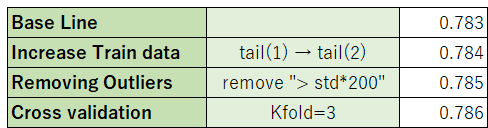

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lightgbm as lgbm
from lightgbm import LGBMClassifier
pd.set_option("display.max_columns", None)

# (1) Baseline [Public Score = 0.783]

My previous LGBM below is the baseline. Please refer to my notebook for the explanation. If you remove the comentout, you can enjoy simple LGBM model which shows Public score 0.783.

前回のシンプルなLGBMモデルをBaselineとしています。こちらの解説については、前回Notebookをご参照ください。コメントアウトを外して実行していただくと、Public Score 0.783のシンプルなLGBMを試していただけます。

In [ ]:
"""
train_df = pd.read_parquet('../input/amex-data-integer-dtypes-parquet-format/train.parquet').groupby('customer_ID').tail(1).set_index('customer_ID', drop=True).sort_index()
train_labels = pd.read_csv('../input/amex-default-prediction/train_labels.csv').set_index('customer_ID', drop=True).sort_index()
train_df = pd.merge(train_df, train_labels, left_index=True, right_index=True)

all_cols = train_df.columns
non_use_cols = ['S_2','B_30','B_38','D_114','D_116','D_117','D_120','D_126','D_63','D_64','D_66','D_68', 'target']
feature_cols = [col for col in all_cols if col not in non_use_cols]

y = train_df['target'].copy()
x = train_df[feature_cols]

model_lgbm = lgbm.LGBMClassifier(n_estimators = 300)
del train_df
del train_labels
model_lgbm.fit(x, y)

test_df = pd.read_parquet('../input/amex-data-integer-dtypes-parquet-format/test.parquet').groupby('customer_ID').tail(1).set_index('customer_ID', drop=True).sort_index()
test_df = test_df[feature_cols]
y_pred  = model_lgbm.predict_proba(test_df)

sub = pd.read_csv('../input/amex-default-prediction/sample_submission.csv')
sub["prediction"] = y_pred[:,1]
sub.to_csv('submission.csv', index=False)
"""

# (2) Increase Train data [Public Score = 0.784]



In baseline above, we read only a single record per each customer (= tail(1)), but if we read 2 records per customer and then train data is increased, Public score is improved from 0.783 to 0.784.  

Trainデータを全量読み込むとメモリーオーバーエラーが頻繁に発生することから、Baselineでは各顧客ごとに１レコード(tail(1))のみ読み込みましたが、これを２レコード（tail(2)）にして訓練データを増やすとPublic Scoreは0.783から0.784へと改善しました。

In [ ]:
train_df = pd.read_parquet('../input/amex-data-integer-dtypes-parquet-format/train.parquet').groupby('customer_ID').tail(2).set_index('customer_ID', drop=True).sort_index()

In [ ]:
train_labels = pd.read_csv('../input/amex-default-prediction/train_labels.csv').set_index('customer_ID', drop=True).sort_index()
train_df = pd.merge(train_df, train_labels, left_index=True, right_index=True)

# (3) Removing Outliers [Public Score = 0.785]

Next, let's see if there are any extreme outliers in train data. This is to see if machine lerning doesn't go well due to those outliers, in other word, to try if public score could be improved by removing them.

続いて、Trainデータの各カラムを見て、極端な外れ値がないか見てみます。極端な外れ値のせいで学習がうまくいっていないか、逆に言うとそれらのレコードを訓練データから除去することでスコアが改善しないか試してみます。

In [ ]:
column_list = train_df.columns
column_list = column_list[2:27]
plt.figure(figsize=(20,20))
for i, column in enumerate(column_list) :
    plt.subplot(5, 5, i+1)
    plt.hist(train_df[f"{column}"], bins=100)
    plt.title(column)
plt.show

You can see many distribution plots are far from normal distribution. Let's check how far max/min is from std.

正規分布から外れたいびつな分布図が多いので、標準偏差からどの程度外れているのかを見てみます。

In [ ]:
train_df.describe()



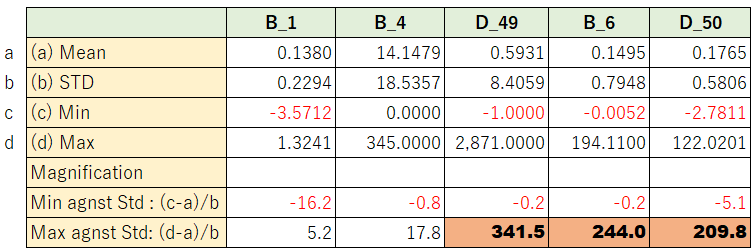

You can see, for example, D49's max is far from Mean by over std x 300, and B_6, D_50 are far from Mean by over std x 200. Let's remove the records which include them.

D_49は標準偏差の300倍以上、B_6・D_50などは200倍以上、平均から乖離していることが分かります。これら極端な外れ値を含むレコードを除去してみます。

In [ ]:
all_cols = train_df.columns
non_use_cols = ['S_2','B_30','B_38','D_114','D_116','D_117','D_120','D_126','D_63','D_64','D_66','D_68', 'target']
feature_cols = [col for col in all_cols if col not in non_use_cols]

In [ ]:
outlier_list = []
outlier_col = []

for col in feature_cols :
    
    temp_df = train_df[(train_df[col] > train_df[col].mean() + train_df[col].std() * 200) |
                       (train_df[col] < train_df[col].mean() - train_df[col].std() * 200) ]
    if len(temp_df) >0 and len(temp_df) <6 : 
        outliers = temp_df.index.to_list()
        outlier_list.extend(outliers)
        outlier_col.append(col)
        print(col, len(temp_df))
    
outlier_list = list(set(outlier_list))

In [ ]:
train_df.drop(outlier_list, inplace = True)
train_df

If you run LGBM using the above train data, Public score will show **0.785**.

これを使って上記のLGBMを実行すると、Public Scoreは**0.785**に改善します。

In [ ]:
y = train_df['target'].copy()
x = train_df[feature_cols]

"""
model_lgbm = lgbm.LGBMClassifier(n_estimators = 300)
del train_df
del train_labels
model_lgbm.fit(x, y)
"""

# (4) Cross validation (KFold = 3) [Public Score = 0.786]

So far, we used simple LGBM baseline. Now let's change to the LGBM model which uses Cross Validation with KFold=3.  
Then, Public score is improved to **0.786**.  

これまで、BaselineのシンプルなLGBMを使ってきましたが、ここで、Trainデータを3分割してCross Validationを行うモデルに変えてみます。  
Public scoreは**0.786**へと改善しました。

In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

kf = KFold(n_splits = 3)
models = []
lgbm_params ={"objective":"binary",
              "random_seed":1234}

for train_index, val_index in kf.split(x):
    X_train = x.iloc[train_index]
    X_valid = x.iloc[val_index]
    Y_train = y.iloc[train_index]
    Y_valid = y.iloc[val_index]
    
    lgbm_train = lgbm.Dataset(X_train, Y_train)
    lgbm_eval = lgbm.Dataset(X_valid, Y_valid, reference=lgbm_train)
    
    model_lgbm = lgbm.train(lgbm_params,
                           lgbm_train,
                           valid_sets = lgbm_eval,
                           num_boost_round = 300,
                           early_stopping_rounds = 20,
                           verbose_eval = 10,
                           )
    y_pred = model_lgbm.predict(X_valid, num_iteration = model_lgbm.best_iteration)
        
    print (accuracy_score(Y_valid, np.round(y_pred)))
    
    models.append(model_lgbm)

In [ ]:
del train_df
del train_labels
del x

In [ ]:
%%time
test_df = pd.read_parquet('../input/amex-data-integer-dtypes-parquet-format/test.parquet').groupby('customer_ID').tail(1).set_index('customer_ID', drop=True).sort_index()
test_df = test_df[feature_cols]

In [ ]:
preds = []

for model in models:
    pred = model.predict(test_df)
    preds.append(pred)
    
preds_array = np.array(preds)
preds_mean = np.mean(preds_array, axis =0)

preds_mean

In [ ]:
sub = pd.read_csv('../input/amex-default-prediction/sample_submission.csv')
sub["prediction"] = preds_mean
sub.to_csv('submission.csv', index=False)
sub.head()